In [1]:

#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정


In [ ]:

#불러오기
merged_train_df = pd.read_csv('./data/semi_train_preprocessed_split2_lbw.csv')
merged_train_df.drop(columns=['Unnamed: 0'],inplace= True)
merged_test_df = pd.read_csv('./data/pretest_preprocessed_split2_lbw.csv')
merged_test_df.drop(columns=['Unnamed: 0'],inplace= True)
merged_train_df.head()


In [2]:
#데이터 불러오기
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
building_info =  pd.read_csv('./data/building_info.csv')

train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

pd.set_option('display.max_columns', 30)

def merge(df):
    df = df.fillna(0)
    date = pd.to_datetime(df.date_time)
    df['hour'] = date.dt.hour
    df['day'] = date.dt.weekday
    df['month'] = date.dt.month
    df['week'] = date.dt.weekofyear
    
    # 'building_number'를 기준으로 두 데이터프레임 병합 및 전처리
    merged_df = pd.merge(df, building_info, on='building_number',how='right')
    #merge후 전처리
    merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].replace('-', 0)
    merged_df['ess_capacity'] = merged_df['ess_capacity'].replace('-', 0)
    merged_df['pcs_capacity'] = merged_df['pcs_capacity'].replace('-', 0)

    merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].astype('float64')
    merged_df['ess_capacity'] = merged_df['ess_capacity'].astype('float64')
    merged_df['pcs_capacity'] = merged_df['pcs_capacity'].astype('float64')
    return merged_df.drop(columns =['num_date_time','building_type'])


merged_train_df_m = merge(train_df)
merged_test_df_m = merge(test_df)

kk = merged_train_df_m.loc[(merged_train_df_m.building_number == 95)&(merged_train_df_m.hour == 16)&(merged_train_df_m.day == 2), 'power_consumption']
sum16 = kk.sum()/12
kkk = merged_train_df_m.loc[(merged_train_df_m.building_number == 95)&(merged_train_df_m.hour == 17)&(merged_train_df_m.day == 2), 'power_consumption']
sum17 = (kkk.sum()-0.36)/12
merged_train_df_m.loc[(merged_train_df_m.building_number == 95)&(merged_train_df_m.hour == 16)&(merged_train_df_m.day == 2)&(merged_train_df_m.month == 7)&(merged_train_df_m.week == 30)
                    , 'power_consumption'] = sum16
merged_train_df_m.loc[(merged_train_df_m.building_number == 95)&(merged_train_df_m.hour == 17)&(merged_train_df_m.day == 2)&(merged_train_df_m.month == 7)&(merged_train_df_m.week == 30)
                    , 'power_consumption'] = sum17

def preprocessing(df):
    # df['day_hour_mean'] = df.progress_apply(lambda x : power_mean.loc[(power_mean.building_number == x['building_number']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'power_consumption'].values[0], axis = 1)
    # df['hour_mean'] = df.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.building_number == x['building_number']) & (power_hour_mean.hour == x['hour']) ,'power_consumption'].values[0], axis = 1)   
    # df['hour_std'] = df.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.building_number == x['building_number']) & (power_hour_std.hour == x['hour']) ,'power_consumption'].values[0], axis = 1)
    
    #######################################
    ## 건물별, 요일별, 전력시간별 소비량 평균 넣어주기
    #######################################
    power_mean = pd.pivot_table(merged_train_df_m, values = 'power_consumption', index = ['building_number', 'hour', 'day'], aggfunc = np.mean).reset_index()
    #######################################
    ## 건물별, 요일별, 전력시간별 소비량 표준편차 넣어주기
    #######################################
    power_std = pd.pivot_table(merged_train_df_m, values = 'power_consumption', index = ['building_number', 'hour', 'day'], aggfunc = np.std).reset_index()
    #######################################
    ## 건물별 시간별 전력소비량 평균 넣어주기
    #######################################
    power_hour_mean = pd.pivot_table(merged_train_df_m, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.mean).reset_index()
    #######################################
    ## 건물별 시간별 전력소비량 표준편차 넣어주기
    #######################################
    power_hour_std = pd.pivot_table(merged_train_df_m, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.std).reset_index()
    
    
    # 병합을 위한 키 설정
    merge_keys = ['building_number', 'hour', 'day']  
    # 데이터프레임 병합
    df = df.merge(power_mean[merge_keys + ['power_consumption']], on=merge_keys, how='left', suffixes=('', '_day_hour_mean'))
    df = df.merge(power_std[merge_keys + ['power_consumption']], on=merge_keys, how='left', suffixes=('', '_day_hour_std'))
    df = df.merge(power_hour_mean[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_hour_mean'))
    df = df.merge(power_hour_std[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_hour_std'))
    df = df.rename(columns = {'power_consumption_day_hour_mean':'day_hour_mean','power_consumption_day_hour_std':'day_hour_std','power_consumption_hour_mean':'hour_mean','power_consumption_hour_std':'hour_std',})
    

    def CDH(xs):
        ys = []
        for i in range(len(xs)):
            if i < 11:
                ys.append(np.sum(xs[:(i+1)]-26))
            else:
                ys.append(np.sum(xs[(i-11):(i+1)]-26))
        return np.array(ys)

    cdhs = np.array([])
    for num in range(1,101,1):
        temp = df[df['building_number'] == num]
        cdh = CDH(temp['temperature'].values)
        cdhs = np.concatenate([cdhs, cdh])
    df['CDH'] = cdhs
    
    ### 공휴일 변수 추가
    df['holiday'] = df.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
    df['date_time'] = df['date_time'].apply(lambda x : int(x[0:8]))
    # df.loc[(df.date_time == 20220601, 'holiday')] = 1
    # df.loc[(df.date_time == 20220606, 'holiday')] = 1
    # df.loc[(df.date_time == 20220815, 'holiday')] = 1
    df.loc[(df.date_time == 20220601, 'holiday')] = 2
    df.loc[(df.date_time == 20220606, 'holiday')] = 2
    df.loc[(df.date_time == 20220815, 'holiday')] = 2

    ## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
    df['sin_time'] = np.sin(2*np.pi*df.hour/24)
    df['cos_time'] = np.cos(2*np.pi*df.hour/24)
    
    ## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
    df['THI'] = 9/5*df['temperature'] - 0.55*(1-df['humidity']/100)*(9/5*df['humidity']-26)+32

    
    return df

merged_train_df_m =preprocessing(merged_train_df_m)
merged_test_df_m =preprocessing(merged_test_df_m).rename(columns = {'power_consumption':'day_hour_mean'})

merged_train_df = pd.DataFrame()
merged_valid_df = pd.DataFrame()
merged_pretest_df = pd.DataFrame()
semi_train_df = pd.DataFrame()
for i in range(1,101,1):
    buff = merged_train_df_m.loc[(merged_train_df_m.building_number == i)]
    semi_train_df = pd.concat([semi_train_df, buff[:-168]])
    merged_train_df = pd.concat([merged_train_df, buff[:-336]])
    merged_pretest_df = pd.concat([merged_pretest_df, buff[-168:]])
    merged_valid_df = pd.concat([merged_valid_df, buff[-336:-168]])

def data_train(df):

    #df['cooling_to_total_area_ratio'] =  df['cooling_area'] / df['total_area']
    
    #grouped = df.groupby(['building_number', 'week', 'day'])
    grouped = df.groupby(['building_number', 'date_time'])

    df['max_power'] = grouped['power_consumption'].transform(np.max)
    df['min_power'] = grouped['power_consumption'].transform(np.min)
    
    #grouped2 = df.groupby(['building_number', 'week', 'day','holiday'])
    grouped2 = df.groupby(['building_number', 'day', 'month'])

    df['max_power'] = grouped2['max_power'].transform(np.mean)
    df['min_power'] = grouped2['min_power'].transform(np.mean)

    #df['solar_to_ess_ratio'] = df['solar_power_capacity'] / df['ess_capacity']
    #df['efficiency'] = df['pcs_capacity'] / df['power_consumption']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0,inplace=True)
    ## StandardScaler 객체 생성
    #from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    ## 데이터 표준화
    # df['solar_to_ess_ratio'] = scaler.fit_transform(df[['solar_to_ess_ratio']])
    # df['efficiency'] = scaler.fit_transform(df[['efficiency']])
    #df.drop(columns=['sunshine','pcs_capacity','ess_capacity','solar_power_capacity','solar_radiation','total_area','cooling_area'],inplace= True)
    df.drop(columns=['cooling_area', 'sunshine','pcs_capacity','ess_capacity','solar_power_capacity','solar_radiation','total_area'],inplace= True)

    return df

def data_test(df):

    #df['cooling_to_total_area_ratio'] =  df['cooling_area'] / df['total_area']
    
    #df.drop(columns=['max_power', 'min_power'])
    grouped_train = merged_train_df.groupby(['building_number', 'day', 'month'])
    max_power = grouped_train['max_power'].median()
    min_power = grouped_train['min_power'].median()
    max_power_df = max_power.reset_index()
    min_power_df = min_power.reset_index()

    # 테스트 데이터에 max_power_median와 min_power_median을 추가
    df = pd.merge(df, max_power_df, on=['building_number', 'day', 'month'])
    df = pd.merge(df, min_power_df, on=['building_number', 'day', 'month'])

    #df['solar_to_ess_ratio'] = df['solar_power_capacity'] / df['ess_capacity']
    #df['efficiency'] = df['pcs_capacity'] / df['power_consumption']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0,inplace=True)
    ## StandardScaler 객체 생성
    #from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    ## 데이터 표준화
    # df['solar_to_ess_ratio'] = scaler.fit_transform(df[['solar_to_ess_ratio']])
    # df['efficiency'] = scaler.fit_transform(df[['efficiency']])
    #df.drop(columns=['pcs_capacity','ess_capacity','solar_power_capacity','total_area','cooling_area'],inplace= True)
    df.drop(columns=['cooling_area','pcs_capacity','ess_capacity','solar_power_capacity','total_area'],inplace= True)

    return df


merged_train_df =data_train(merged_train_df)
merged_test_df =data_test(merged_test_df_m)

final_train_df = data_train(merged_train_df_m)
merged_pretest_df =data_test(merged_pretest_df)
merged_valid_df =data_test(merged_valid_df)
merged_semi_train_df =data_train(semi_train_df)

merged_pretest_df = merged_pretest_df.drop(columns = 'sunshine')
merged_pretest_df = merged_pretest_df.drop(columns = 'solar_radiation')
merged_valid_df = merged_valid_df.drop(columns = 'sunshine')
merged_valid_df = merged_valid_df.drop(columns = 'solar_radiation')

In [3]:
final_train_df.drop(columns=['date_time']).to_csv('./data/final_train_preprocessed_month_lbw.csv')
merged_valid_df.drop(columns=['date_time']).to_csv('./data/valid_preprocessed_month_lbw.csv')
merged_pretest_df.drop(columns=['date_time']).to_csv('./data/pretest_preprocessed_month_lbw.csv')
merged_semi_train_df.drop(columns=['date_time']).to_csv('./data/semi_train_preprocessed_month_lbw.csv')
merged_test_df.drop(columns=['date_time']).to_csv('./data/test_preprocessed_month_lbw.csv')
merged_train_df.drop(columns=['date_time']).to_csv('./data/train_preprocessed_month_lbw.csv')

best iterations: 174
SMAPE : 34.78341486240471


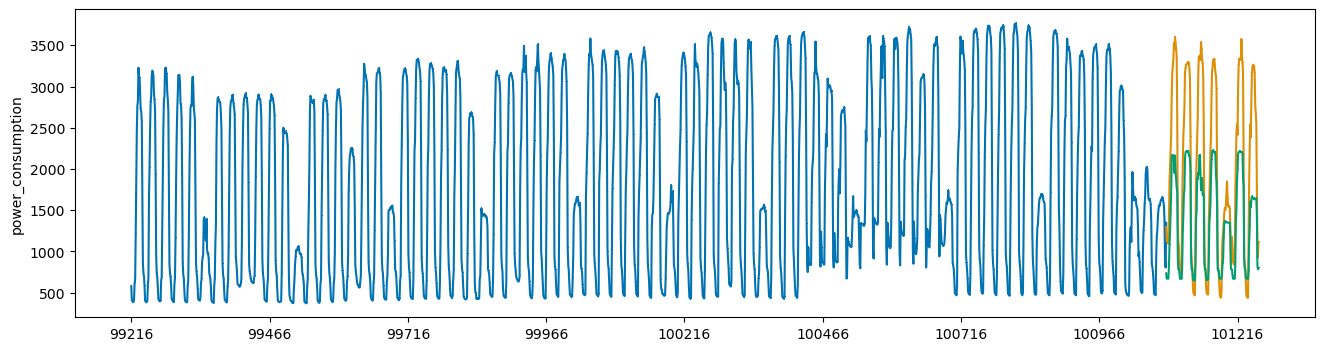

In [5]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

xgb_params =  pd.read_csv('./parameters\hyperparameter_xgb_split2_lbw.csv')
#Smape_buildnum = []
#merged_train_df = data(merged_train_df)
## 54번 건물의 발전량
bnum = 54
y_train = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
x_train = merged_train_df.loc[merged_train_df.building_number == bnum, ].drop(columns=['power_consumption'])
y_valid = merged_test_df.loc[merged_test_df.building_number == bnum, 'power_consumption']
x_valid = merged_test_df.loc[merged_test_df.building_number == bnum, ].drop(columns=['power_consumption'])
#y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168


## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
## mse가중치 사용 O

xgb_reg = XGBRegressor(n_estimators = xgb_params.iloc[bnum-1,7], eta = xgb_params.iloc[bnum-1,1], min_child_weight = xgb_params.iloc[bnum-1,2], 
                       max_depth = xgb_params.iloc[bnum-1,3], colsample_bytree = xgb_params.iloc[bnum-1,4], 
                       subsample = xgb_params.iloc[bnum-1,5], seed=0)
if xgb_params.iloc[bnum-1,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb_reg.set_params(**{'objective':weighted_mse(xgb_params.iloc[bnum-1,6])})

#xgb_reg.set_params(**{'objective':weighted_mse(100)})
xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_train.index[-1], y_train.index[-1]+len(y_valid))
y_valid.index = np.arange(y_train.index[-1], y_train.index[-1]+len(y_valid))
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))
#Smape_buildnum.append([bnum, xgb_reg.best_iteration, SMAPE(y_valid, pred)])

best iterations: 202
SMAPE : 24.742782533502726


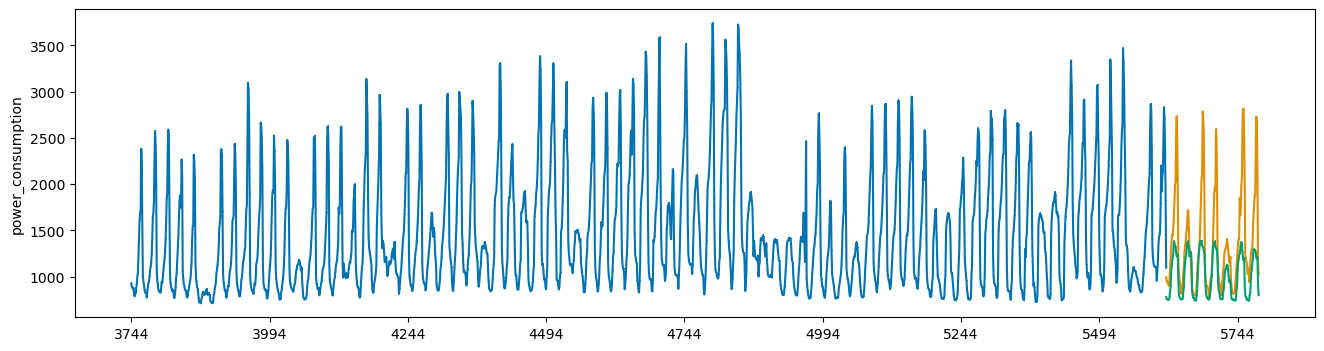

In [11]:
def weighted_rmse(alpha = 1):
    def weighted_rmse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual/np.abs(residual), -2*residual/np.abs(residual))
        hess = np.where(residual>0, 2*alpha/np.abs(residual), 2.0/np.abs(residual))
        return grad, hess
    return weighted_rmse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

xgb_params =  pd.read_csv('./parameters\hyperparameter_xgb_split2_lbw.csv')
#Smape_buildnum = []
#merged_train_df = data(merged_train_df)
## 54번 건물의 발전량
bnum = 3
y_train = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
x_train = merged_train_df.loc[merged_train_df.building_number == bnum, ].drop(columns=['power_consumption'])
y_valid = merged_test_df.loc[merged_test_df.building_number == bnum, 'power_consumption']
x_valid = merged_test_df.loc[merged_test_df.building_number == bnum, ].drop(columns=['power_consumption'])
#y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
## mse가중치 사용 O
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb_holly2_lbw.csv')

xgb_reg = XGBRegressor(n_estimators = xgb_params.iloc[bnum-1,7], eta = xgb_params.iloc[bnum-1,1], min_child_weight = xgb_params.iloc[bnum-1,2], 
                       max_depth = xgb_params.iloc[bnum-1,3], colsample_bytree = xgb_params.iloc[bnum-1,4], 
                       subsample = xgb_params.iloc[bnum-1,5], seed=0)
if xgb_params.iloc[bnum-1,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb_reg.set_params(**{'objective':weighted_rmse(xgb_params.iloc[bnum-1,6])})

#xgb_reg.set_params(**{'objective':weighted_mse(100)})
xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_train.index[-1], y_train.index[-1]+len(y_valid))
y_valid.index = np.arange(y_train.index[-1], y_train.index[-1]+len(y_valid))
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))
#Smape_buildnum.append([bnum, xgb_reg.best_iteration, SMAPE(y_valid, pred)])

Feature 0: 0.0
Feature 1: 0.001043218420818448
Feature 2: 0.0002540719578973949
Feature 3: 0.0003197576152160764
Feature 4: 0.00048110654461197555
Feature 5: 0.043259330093860626


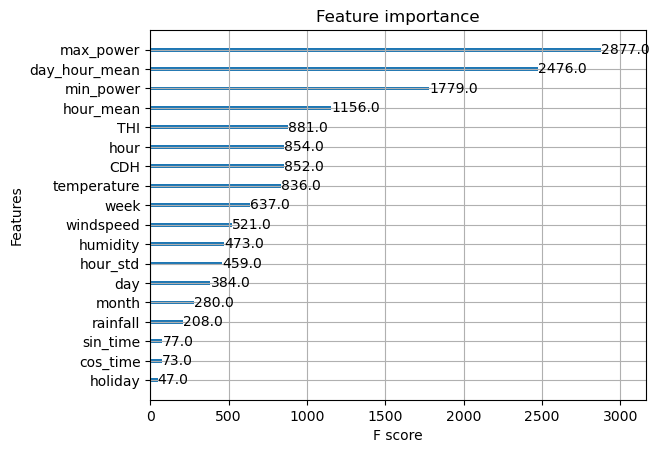

In [24]:
import xgboost as xgb
import matplotlib.pyplot as plt

#Features = []

# 피처 중요도 확인
feature_importances = xgb_reg.feature_importances_

# 피처 중요도를 출력합니다.(위에서 5개만)
for i, feat_importance in enumerate(feature_importances):
  if i <6:
    print(f"Feature {i}: {feat_importance}")

Features.append(feature_importances)

# 피처 중요도를 시각화합니다.
xgb.plot_importance(xgb_reg)
plt.show()

iterations: 가중치 편향 업데이트 횟수 오... 

In [46]:
merged_train_df = pd.read_csv('./data/train_preprocessed_add_lbw.csv').drop(columns = 'Unnamed: 0')
merged_test_df = pd.read_csv('./data/test_preprocessed_add_lbw.csv').drop(columns = 'Unnamed: 0')
#merged_test2 = pd.read_csv('./data/test_preprocessed_add_lbw.csv').drop(columns = 'Unnamed: 0')

grouped = merged_train_df.groupby(['building_number', 'day'])
#merged_test_df.drop(columns=['max_power', 'min_power'])
max = grouped['max_power'].transform('median')
min = grouped['min_power'].transform('median')
merged_test_df['max_power'] = max
merged_test_df['min_power'] = min


In [48]:
merged_train_df = pd.read_csv('./data/train_preprocessed_add_lbw.csv').drop(columns = 'Unnamed: 0')
merged_test_df = pd.read_csv('./data/test_preprocessed_add_lbw.csv').drop(columns = 'Unnamed: 0')
#merged_test2 = pd.read_csv('./data/test_preprocessed_add_lbw.csv').drop(columns = 'Unnamed: 0')
# 건물 번호와 요일을 기준으로 그룹화하여 max_power와 min_power의 중앙값을 찾아서 새로운 DataFrame 생성
merged_test_df.drop(columns=['max_power', 'min_power'])
grouped_train = merged_train_df.groupby(['building_number', 'day'])
max_power_median = grouped_train['max_power'].median()
min_power_median = grouped_train['min_power'].median()
max_power_median_df = max_power_median.reset_index()
min_power_median_df = min_power_median.reset_index()

# 테스트 데이터에 max_power_median와 min_power_median을 추가
merged_test_df = pd.merge(merged_test_df, max_power_median_df, on=['building_number', 'day'], how='left')
merged_test_df = pd.merge(merged_test_df, min_power_median_df, on=['building_number', 'day'], how='left')

# 결과 확인
print(merged_test_df.head())

   building_number  temperature  rainfall  windspeed  humidity  hour  day  \
0                1         23.5       0.0        2.2        72     0    3   
1                1         23.0       0.0        0.9        72     1    3   
2                1         22.7       0.0        1.5        75     2    3   
3                1         22.1       0.0        1.3        78     3    3   
4                1         21.8       0.0        1.0        77     4    3   

   month  week  day_hour_mean  ...  holiday  sin_time  cos_time      THI  \
0      8    34        1627.80  ...        0  0.000000  1.000000  58.3456   
1      8    34        1550.08  ...        0  0.258819  0.965926  57.4456   
2      8    34        1431.12  ...        0  0.500000  0.866025  57.8725   
3      8    34        1372.20  ...        0  0.707107  0.707107  57.9376   
4      8    34        1381.72  ...        0  0.866025  0.500000  56.9961   

   cooling_to_total_area_ratio  max_power_x  min_power_x  solar_to_ess_ratio  \


 10%|█         | 1/10 [00:01<00:11,  1.24s/it]

best iterations: 438
SMAPE : 28.074004696958447


 20%|██        | 2/10 [00:02<00:08,  1.03s/it]

best iterations: 316
SMAPE : 17.06639566642092


 30%|███       | 3/10 [00:02<00:06,  1.13it/s]

best iterations: 201
SMAPE : 19.187480379713513


 40%|████      | 4/10 [00:03<00:04,  1.22it/s]

best iterations: 304
SMAPE : 13.138581583970188


 50%|█████     | 5/10 [00:06<00:07,  1.45s/it]

best iterations: 740
SMAPE : 26.74446053307858


 60%|██████    | 6/10 [00:07<00:05,  1.34s/it]

best iterations: 482
SMAPE : 19.967343592589664


 70%|███████   | 7/10 [00:07<00:03,  1.11s/it]

best iterations: 266
SMAPE : 16.77987272987174


 80%|████████  | 8/10 [00:08<00:01,  1.02it/s]

best iterations: 413
SMAPE : 24.040749519754176


 90%|█████████ | 9/10 [00:09<00:00,  1.14it/s]

best iterations: 414
SMAPE : 32.96650199574421


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

best iterations: 281
SMAPE : 34.981054508937845


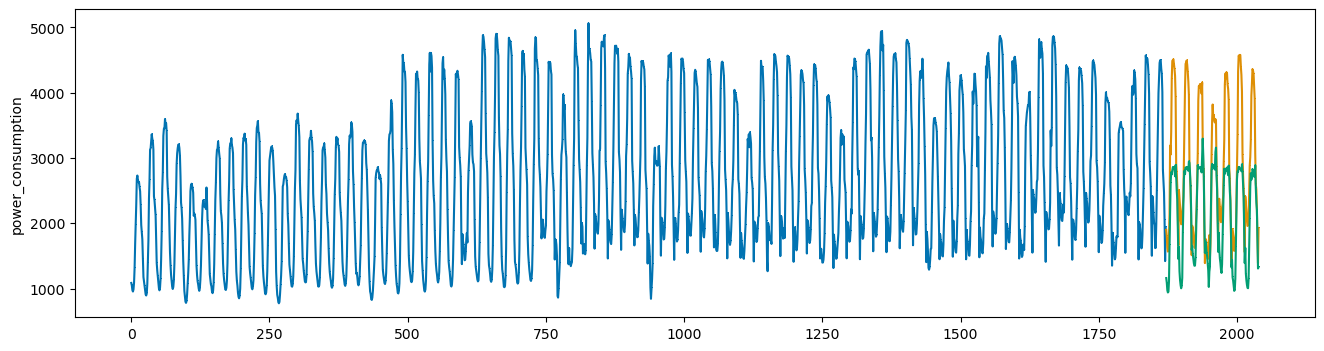

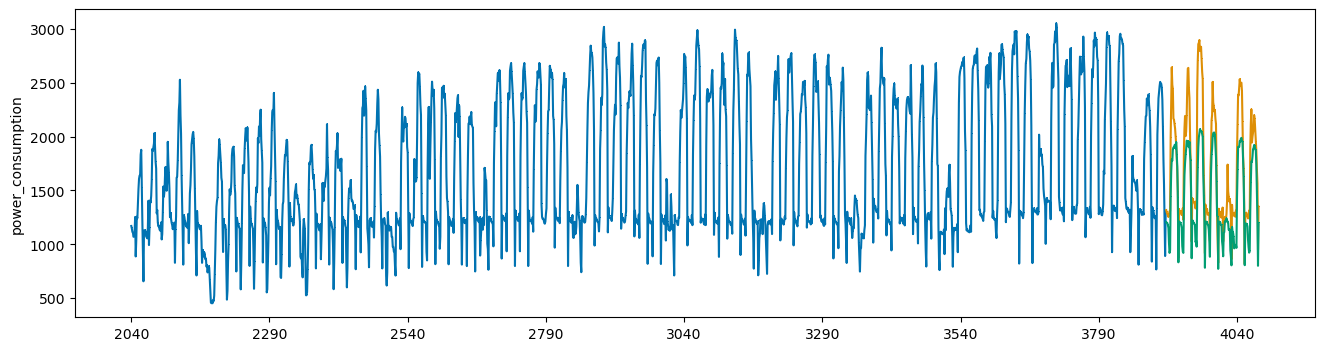

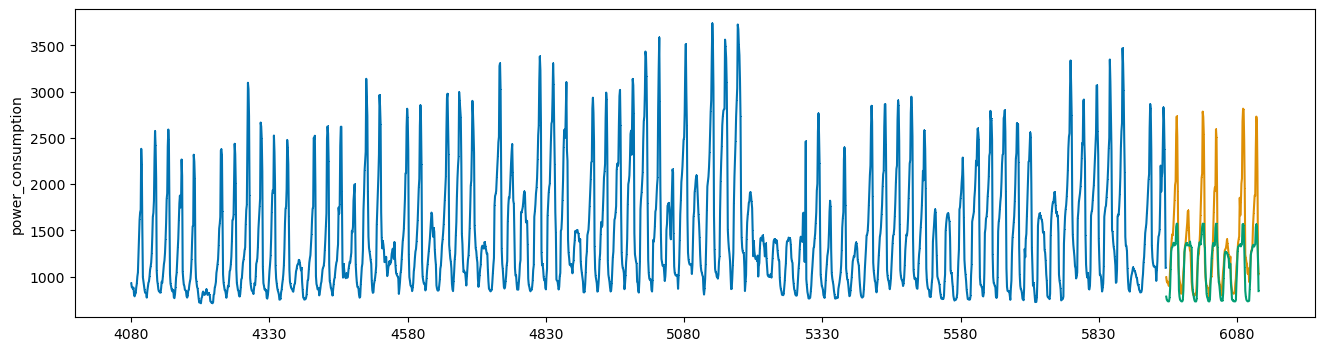

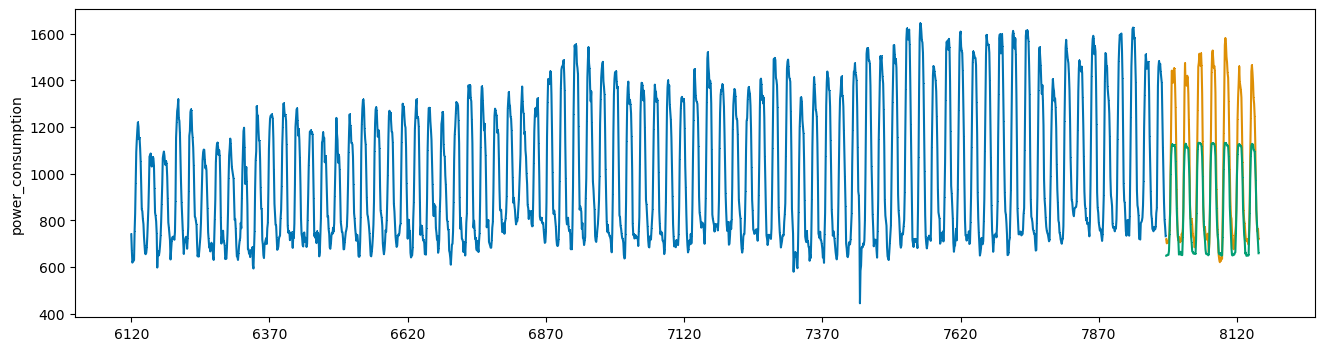

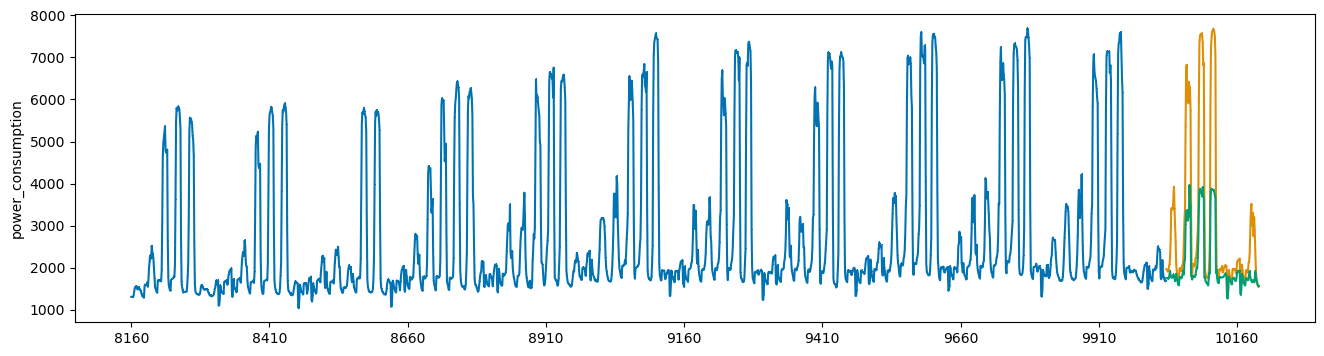

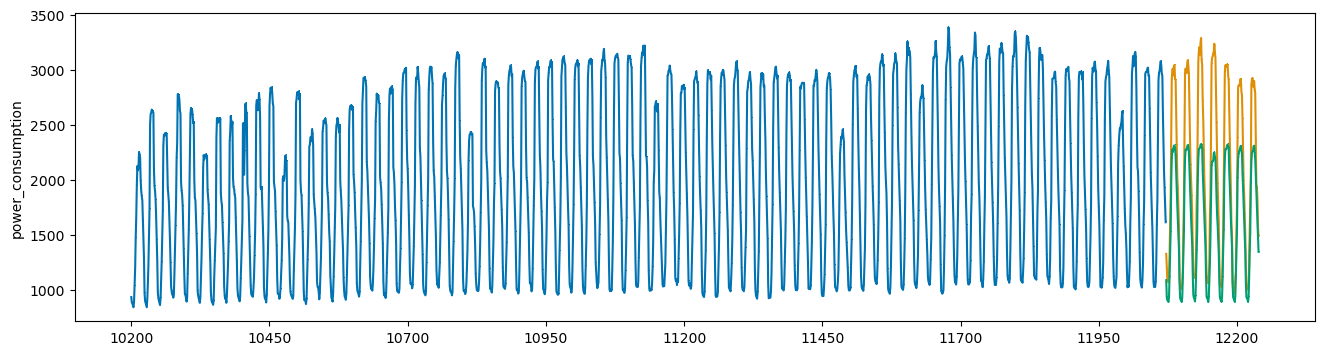

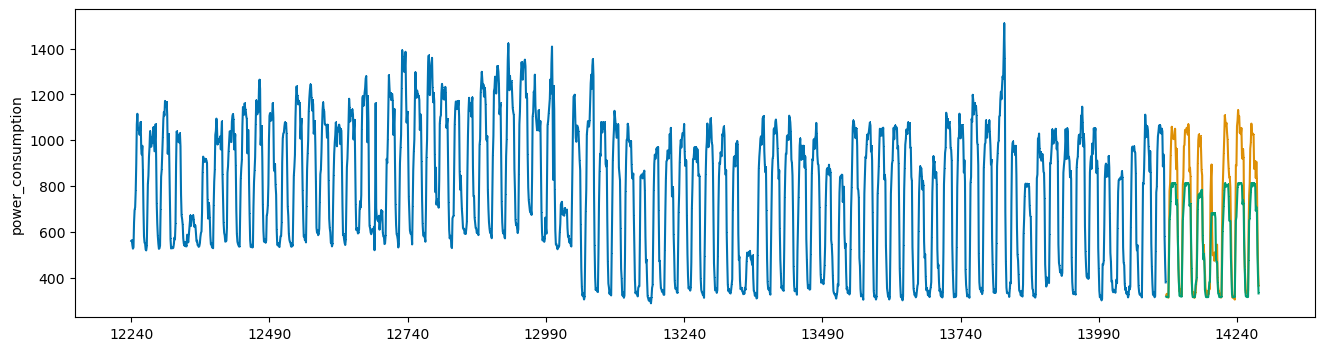

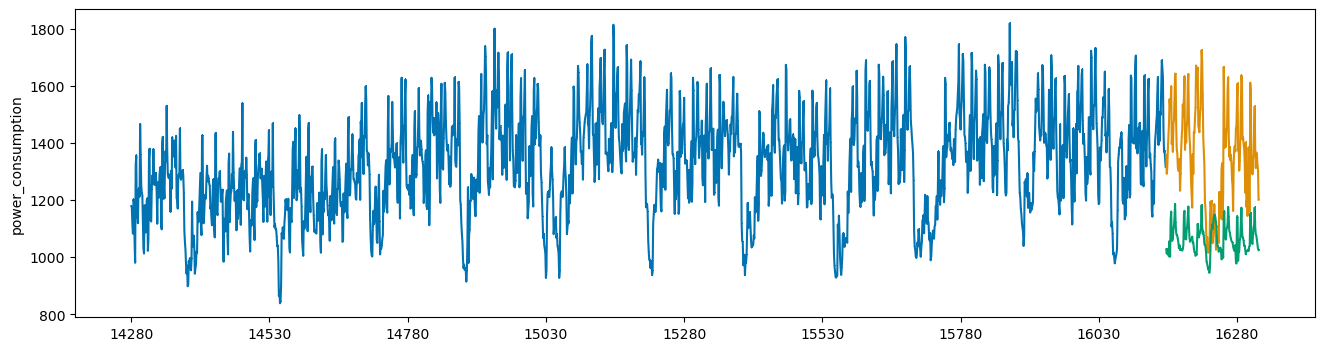

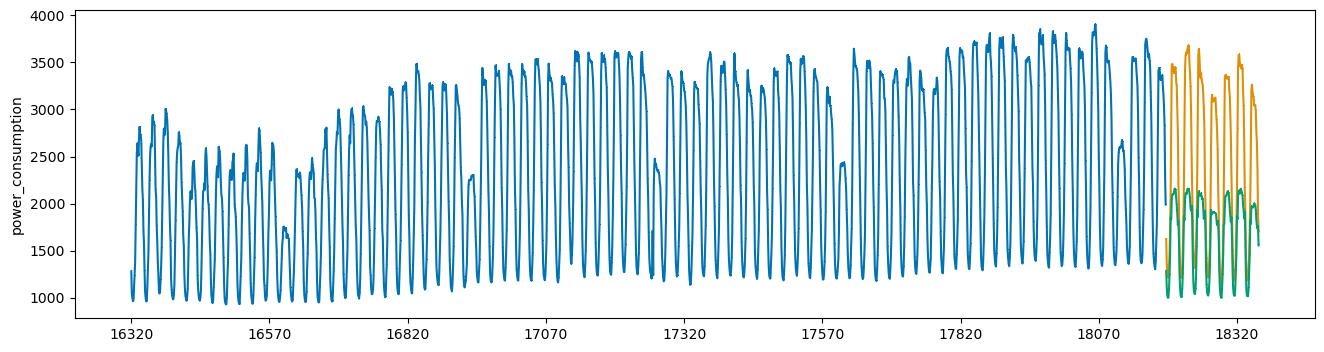

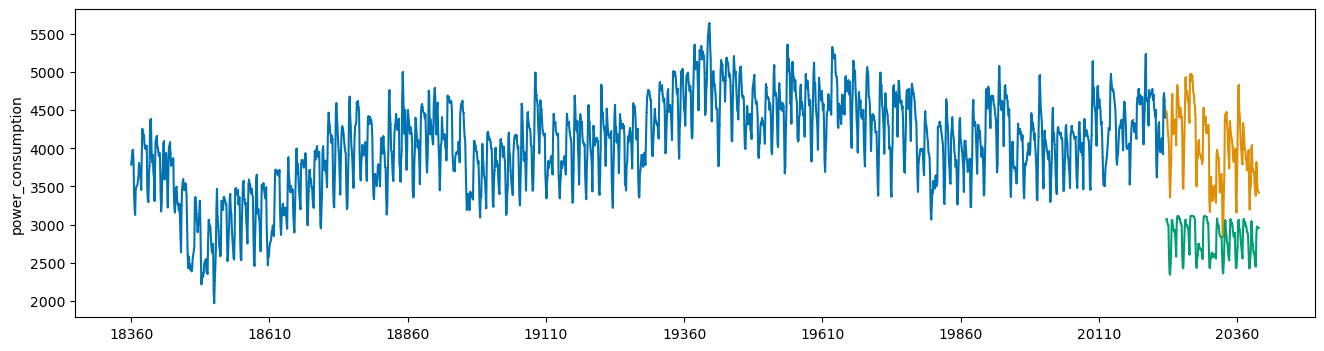

In [38]:

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

xgb_params = pd.read_csv('./parameters/hyperparameter_xgb_wsw.csv').drop(columns = 'Unnamed: 0')
Smape_buildnum=[]
Features=[]

for bnum in tqdm(np.arange(1,11,1)):

    y = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
    x = merged_train_df.loc[merged_train_df.building_number == bnum, ].drop(columns=['power_consumption'])

    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

    
    grouped = x_train.groupby(['building_number', 'day'])

    x_valid.drop(columns=['max_power', 'min_power'])
    
    x_valid['max_power'] = grouped['max_power'].transform(np.median)
    x_valid['min_power'] = grouped['min_power'].transform(np.median)

    ## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
    ## mse가중치 사용 O


    xgb_reg = XGBRegressor(n_estimators = xgb_params.iloc[bnum-1,7], eta = xgb_params.iloc[bnum-1,1], min_child_weight = xgb_params.iloc[bnum-1,2], 
                        max_depth = xgb_params.iloc[bnum-1,3], colsample_bytree = xgb_params.iloc[bnum-1,4], 
                        subsample = xgb_params.iloc[bnum-1,5], seed=0)
    if xgb_params.iloc[bnum-1,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
                xgb_reg.set_params(**{'objective':weighted_mse(xgb_params.iloc[bnum-1,6])})

    #xgb_reg.set_params(**{'objective':weighted_mse(100)})
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
            early_stopping_rounds=300,
        verbose=False)

    pred = xgb_reg.predict(x_valid)
    pred = pd.Series(pred)
    pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
    plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

    print('best iterations: {}'.format(xgb_reg.best_iteration))
    print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

    Smape_buildnum.append([bnum, xgb_reg.best_iteration, SMAPE(y_valid, pred)])

    # 피처 중요도 확인
    feature_importances = xgb_reg.feature_importances_

    Features.append(feature_importances)